Import libraries

In [541]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

Initialize data structures

In [3]:
# define adni dictionaries
apo_dict = pd.read_csv("Biomarker Data/APOERES_DICT.csv")
csf_dict = pd.read_csv("Biomarker Data/UPENNBIOMK_MASTER_DICT.csv")
lab_dict = pd.read_csv("Biomarker Data/LABDATA_DICT.csv")
adni_dict_df = pd.read_csv("study info/DATADIC.csv")

In [4]:
# define dataframes
apo_df = pd.read_csv("Biomarker Data/APOERES.csv")
csf_df = pd.read_csv("Biomarker Data/UPENNBIOMK_MASTER.csv")
lab_df =  pd.read_csv("Biomarker Data/LABDATA.csv")

In [173]:
# print term definitions and codes, and 
def define_terms(data_df, dict_df, table_name=None, columns=None):
    
    if columns is None:
        columns = data_df.columns
    if table_name is None:
        keys = ["FLDNAME","TYPE","TEXT","CODE"]
    else:
        keys = ["FLDNAME","TYPE","TBLNAME","TEXT","CODE"]
        
    term_dicts = []
    for col in columns:

        term_dict = dict.fromkeys(keys)
        if table_name is None:
            loc = (dict_df.FLDNAME == col)
        else:
            loc = (dict_df.FLDNAME == col) & (dict_df.TBLNAME == table_name)
        tmp = dict_df.loc[loc][keys]
        
        for key in keys:
            if tmp[key].unique().shape[0]:
                term_dict[key] = tmp[key].unique()[0]
            else:
                term_dict[key] = float('nan')
        
        term_dicts.append(term_dict)
        #print("Name: {FLDNAME},\nType: {TYPE},\nTable: {TBLNAME},\nDesc: {TEXT},\nCode:{CODE}\n".format(**term_dict))
    
    data_dict = pd.DataFrame.from_dict(term_dicts).reindex(columns=keys)
    return(data_dict)
        

In [6]:
def paths_with_ext(directory=None, extension=".csv"):

    if directory is None:
        directory = os.getcwd()

    matches=[]
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(extension):
                matches.append(os.path.join(root, filename))
                
    return(matches)

In [7]:
# report num entries, columns, patients, and range of num records and phases covered
def describe_meta_data(df):

    by_patient = df.groupby("RID")
    nRecords = by_patient.apply(len)
    #starting_phase = by_patient.apply(lambda x: x.Phase.unique()[0])
    nPatients = nRecords.shape[0]
    if "Phase" in df.columns:
        nPhases = by_patient.apply(lambda x: len(x.Phase.unique()))
    else:
        nPhases = 0
    duplicate_in_phase  = np.sum(nRecords != nPhases)    
    
    print("Num Entries:\t %i\nNum Columns: %i" % (df.shape[0],df.shape[1]))
    print("Num Patients:\t %i\nRecords per Patient:\t %i-%i\nPhases Spanned:\t %i-%i\nPatients w/ Duplicates:\t %i\n" \
         % (nPatients,np.min(nRecords),np.max(nRecords),np.min(nPhases),np.max(nPhases),duplicate_in_phase))

In [8]:
# add new patient_data from  by-patient dataframe
def combine_patient_data(pat_df, new_df):
    
    # intialize empty placeholder columns in patient data
    new_cols = new_df.columns
    
    # remove duplicate columns
    new_cols = list(set(new_cols)-set(pat_df.columns))
    pat_df = pat_df.reindex(columns=pat_df.columns.tolist() + new_cols)
    
    # compare list of patient IDs
    old_RIDs = pat_df.index
    new_RIDs = new_df.index
    is_old= np.in1d(new_RIDs,old_RIDs)
    
    # grab data from existing patient list to insert into pat_df
    insert_mat = new_df.loc[is_old, new_cols].values
    
    #import pdb;pdb.set_trace()
    pat_df.loc[new_RIDs[is_old],new_cols] = insert_mat
    
    # append new patient data from RIDs non-existent in pat_df
    pat_df = pat_df.append(new_df.loc[~is_old], sort=True)
    
    return(pat_df)

**ApoE MEASUREMENTS**

In [9]:
describe_meta_data(apo_df)

Num Entries:	 2067
Num Columns: 16
Num Patients:	 2067
Records per Patient:	 1-1
Phases Spanned:	 1-1
Patients w/ Duplicates:	 0



The APOERES table contains information about patient alleles for the ApoE gene which has been linked to alzheimers.

In [10]:
# define and print terms from apo table
term_defs = define_terms(apo_df, adni_dict_df, "APOERES")
term_defs

,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,NaN,NaN,NaN,NaN,NaN
1,ID,N,APOERES,Record ID,"""crfname"",""ApoE Genotyping - Results"",""indexes..."
2,RID,N,APOERES,Participant roster ID,NaN
3,SITEID,N,APOERES,Site ID,NaN
4,VISCODE,T,APOERES,Visit code,NaN
5,USERDATE,S,APOERES,Date record created,NaN
6,USERDATE2,S,APOERES,Date record last updated,NaN
7,APTESTDT,D,APOERES,Date Test Performed,NaN
8,APGEN1,N,APOERES,Genotype - Allele 1,2..4
9,APGEN2,N,APOERES,Genotype - Allele 2,2..4


In [11]:
apo_cols = ["APGEN1","APGEN2"]

**BIOMARKER MASTER**

UPENN Biomarker master table contains abeta, tau, and ptau measurements.

In [12]:
# define and print terms from CSF biomarker master table
term_defs = define_terms(csf_df, csf_dict, "UPENNBIOMK_MASTER")
term_defs

,FLDNAME,TYPE,TBLNAME,TEXT,CODE
0,RID,-4.0,UPENNBIOMK_MASTER,Participant roster ID,NaN
1,VISCODE,-4.0,UPENNBIOMK_MASTER,Visit code,NaN
2,BATCH,-4.0,UPENNBIOMK_MASTER,"Name of LONI table, corresponding to analytica...",NaN
3,KIT,-4.0,UPENNBIOMK_MASTER,Reagents lot number,NaN
4,STDS,-4.0,UPENNBIOMK_MASTER,Calibrators and Quality Controls lot number,NaN
5,NaN,NaN,NaN,NaN,NaN
6,RUNDATE,-4.0,UPENNBIOMK_MASTER,Date of analytical run,NaN
7,ABETA,-4.0,UPENNBIOMK_MASTER,Result rescaled to UPENNBIOMK,NaN
8,TAU,-4.0,UPENNBIOMK_MASTER,Result rescaled to UPENNBIOMK,NaN
9,PTAU,-4.0,UPENNBIOMK_MASTER,Result rescaled to UPENNBIOMK,NaN


In [13]:
csf_cols = ["ABETA","TAU","PTAU"]

In [14]:
describe_meta_data(csf_df)

Num Entries:	 5876
Num Columns: 14
Num Patients:	 1249
Records per Patient:	 2-26
Phases Spanned:	 0-0
Patients w/ Duplicates:	 1249



**LAB DATA**

In [15]:
# define and print terms from CSF biomarker master table
describe_meta_data(lab_df)

Num Entries:	 2463
Num Columns: 131
Num Patients:	 2285
Records per Patient:	 1-3
Phases Spanned:	 1-1
Patients w/ Duplicates:	 171



In [16]:
# create a function to extract lab codes from the lab dict (has a different structure from other dictionaries)
def define_labcodes(df, dict_df):
    
    keys=["Test Code","Test Description"]
    term_dicts = []
    for col in df.columns:

        term_dict = dict.fromkeys(keys)
        loc = (dict_df["Test Code"] == col)
        
        if any(loc):
            tmp = dict_df.loc[loc][keys]

            for key in keys:
                if tmp[key].unique().shape[0]:
                    term_dict[key] = tmp[key].unique()[0]
                else:
                    term_dict[key] = float('nan')

            term_dicts.append(term_dict)
            #print("Name: {FLDNAME},\nType: {TYPE},\nTable: {TBLNAME},\nDesc: {TEXT},\nCode:{CODE}\n".format(**term_dict))
    
    data_dict = pd.DataFrame.from_dict(term_dicts).reindex(columns=keys)
    return(data_dict)

In [17]:
# extract lab codes and descriptions of each test
lab_codes = define_labcodes(lab_df, lab_dict)
lab_codes.head(10)


,Test Code,Test Description
0,AXT117,Thyroid Stim. Hormone-QT
1,BAT126,Vitamin B12
2,CMT1,Color-QT
3,CMT10,Urine Nitrite-QT
4,CMT11,Leukocyte Esterase-QT
5,CMT2,Specific Gravity-QT
6,CMT3,pH-QT
7,CMT43,Blood (+)-QT
8,CMT49,Urine Protein (3+)-QT
9,CMT5,Urine Glucose-QT


In [365]:
# record all lab codes and use them to extract lab code data from 
lab_cols = lab_codes["Test Code"]

Let's move on to missing data for this data set.

From the ADNI website:

>**Laboratory Data**: Screening clinical lab results (i.e. urine, chemistry panel).
Data contains some character coding (i.e. SCC09: No specimen received ), and
they can be treated as missing data. (LABDATA.csv)


In [352]:
# determine if a string contains any non numeric characters
def is_number(string: str):
    
    # define valid numeric characters 
    # (including decimal and negative sign)
    valid_chars = set(str(np.arange(0,10,1))[1:-1] + '.-')
    is_num = not bool(set(string)-valid_chars)
    return(is_num)

In [368]:
# find columns of lab df with strings
str_cols = lab_df[lab_cols].dtypes == object
str_cols = lab_cols[str_cols.values]

In [376]:
# define function to replace missing data with NaN
str_isnumber = lab_df[str_cols].apply(lambda x: x.apply(str_isnum))

In [394]:
# convert values with strings to missing val (-1)
str_vals = lab_df[str_cols].values
str_vals[~str_isnumber] = '-1'
num_vals = str_vals.astype(float)

# store new numeric values in dataframe
lab_df[str_cols] = num_vals

# look for columns where all values are missing
# and remove them from the list of columns
all_missing_cols = str_cols[(num_vals==-1).all(0)]
lab_cols = list(set(lab_cols) - set(all_missing_cols))

In [397]:
# check to make sure all of our data is numeric
lab_df[lab_cols].dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [37]:
def patient_num_records(df):
    
    # get indices grouped by patient
    n_measurements = df.groupby("RID").apply(lambda x: x.shape[0])
    
    return(n_measurements)

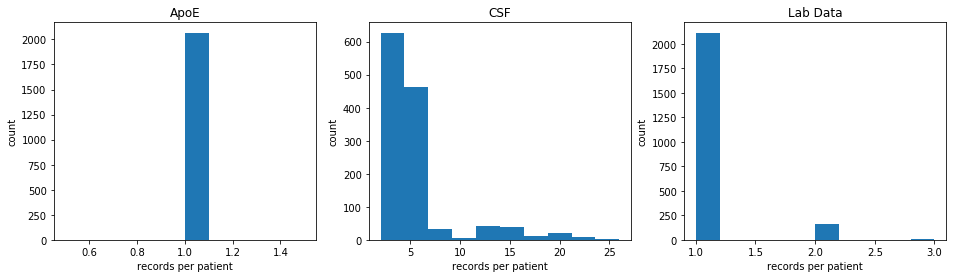

In [181]:
# lets look at the break-down of duplicate RIDs
all_dfs = [apo_df, csf_df, lab_df]
df_names = ["ApoE","CSF","Lab Data"]
plt.figure(figsize=(16,4))
for i,df in enumerate(all_dfs):
    _, _, n = patient_first_last_idx(df)
    plt.subplot(1,len(all_dfs),i+1)
    plt.hist(n)
    plt.xlabel("records per patient")
    plt.ylabel("count")
    plt.title(df_names[i])

In [23]:
# build a dataframe with the first entry for each patient
def patient_first_entry_data(df):
    by_RID = df.groupby("RID")
    first_entry_dat = by_RID.apply(lambda x: x.apply(lambda y: y.iloc[0]))
    return(first_entry_dat)

In [24]:
# get first entry for each df
all_df_cols = [apo_cols, csf_cols, lab_cols]

# iterate over dataframes
for i,df in enumerate(all_dfs):
    
    # restrict to column subset of df
    # ensure RID is in column list
    cols = all_df_cols[i]
    if "RID" not in cols:
        cols.append("RID")
    
    # if not first iteration
    if i:
        # get first entry for each patient
        tmp_df = patient_first_entry_data(df[cols])
        
        # append to per patient df
        pat_df = combine_patient_data(pat_df, df[cols])
    else:
        # initialize per patient df
        pat_df = patient_first_entry_data(df[cols])


In [25]:
pat_df.shape

(5876, 150)

**Breakdown by VISCODE**

Let's take a look at the number of records/unique entries for each patient as a function of `VISCODE` to see if we can find a reasonable way to split of the data. One option is to apply the `patient_first_last_idx` function defined above to the data grouped by `VISCODE`.

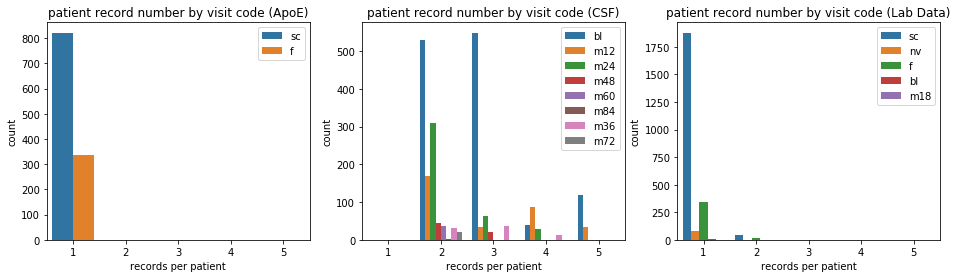

In [186]:
grp = "VISCODE2"
bins = np.arange(1,7,1)
nbins = bins.shape[0]-1
plt.figure(figsize=(16,4))
for i,df in enumerate(all_dfs):
    
    # create subplot for histogram of each df
    if "VISCODE2" in df.columns:
        grp="VISCODE2"
    else:
        grp = "VISCODE"
    by_viscode = df.groupby(grp)
    records_per_viscode = by_viscode.apply(patient_num_records)
    
    # get viscodes from df
    viscodes = df[grp].dropna().unique()
    nv = viscodes.shape[0]
    vc = np.tile(viscodes,nbins)
    tmp_counts = np.zeros(viscodes.shape[0]*nbins)
    tmp_n = np.tile(np.arange(1,nbins+1,1).reshape(-1,1),nv).reshape(-1,nv).flatten()
    tmp_df = pd.DataFrame(data=np.vstack((vc,tmp_n,tmp_counts)).T, columns=[grp,"records","count"])
    
    plt.subplot(1,len(all_dfs),i+1)
    for j,code in enumerate(viscodes):
        
        # count num in each category
        tmp_df.loc[tmp_df[grp]==code,'count'] = np.histogram(records_per_viscode[code].values, bins)[0]
        
    sns.barplot(x="records", y="count", hue=grp, data=tmp_df)    

    plt.xlabel("records per patient")
    plt.ylabel("count")
    plt.title("patient record number by visit code ({})".format(df_names[i]))
    plt.legend()
    

**Diagnostic Summary Analysis**

In [193]:
# read in data and print summary of terms
dx_df = pd.read_csv("Diagnosis/DXSUM_PDXCONV_ADNIALL.csv")
dx_terms = define_terms(dx_df, adni_dict_df)

,FLDNAME,TYPE,TEXT,CODE
0,NaN,NaN,NaN,NaN
1,ID,N,Record ID,"""crfname"","""",""indexes"",""adni_aal_idx=TBLID,FLD..."
2,RID,N,Participant roster ID,NaN
3,SITEID,N,Site ID,NaN
4,VISCODE,T,Visit code,NaN
5,VISCODE2,-4,Translated visit code,-4
6,USERDATE,S,Date record created,NaN
7,USERDATE2,S,Date record last updated,NaN
8,EXAMDATE,D,Examination Date,NaN
9,DXCHANGE,N,1. Which best describes the participant's cha...,1=Stable: NL to NL; 2=Stable: MCI to MCI; 3=St...


In [291]:
# specify columns of interest from diagnostic data
dx_cols = ["DXNORM","DXNODEP","DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXPARK","DXDEP","DXOTHDEM"]

We can see from the summary above that there are many diagnostic summaries which take the form of comments on previous categories. These will have to be removed. Also, many of the categories are dependent on previous categories, those should probably be removed as well.

In [284]:
# print the values for DXCHANGE
print(dx_terms.loc[dx_terms.FLDNAME=="DXCHANGE"].CODE.values)
print(dx_terms.loc[dx_terms.FLDNAME=="DIAGNOSIS"].CODE.values)

['1=Stable: NL to NL; 2=Stable: MCI to MCI; 3=Stable: Dementia to Dementia; 4=Conversion: NL to MCI; 5=Conversion: MCI to Dementia; 6=Conversion: NL to Dementia; 7=Reversion: MCI to NL; 8=Reversion: Dementia to MCI; 9=Reversion: Dementia to NL']
["1=Cognitively Normal; 5=Significant Memory Concern;2=Early MCI; 3=Late MCI; 4=Alzheimer's Disease"]


In [209]:
# response var
describe_meta_data(dx_df)

Num Entries:	 11264
Num Columns: 53
Num Patients:	 2516
Records per Patient:	 1-15
Phases Spanned:	 1-4
Patients w/ Duplicates:	 2024



In [278]:
# look at number of diagnostic values for each phase
by_phase = dx_df.groupby("Phase")
n_missing_per_phase = by_phase[["DXCURREN","DXCHANGE","DIAGNOSIS"]].apply(lambda x: x.shape[0]-x.isna().sum())
n_missing_per_phase

,DXCURREN,DXCHANGE,DIAGNOSIS
Phase,,,
ADNI1,3868,0,0
ADNI2,0,5638,0
ADNI3,0,0,1281
ADNIGO,0,475,0


In [408]:
n_missing_per_phase.values.sum()

11262

We can tell from the table above that we have different diagnostic summary categories for different phases of ADNI. We can make a more or less complete list of diagnoses by combining these three categories into one.

In [280]:
# convert DXCHANGE to DX, NL=(1,7,9), MCI=(2,4,8), AD=(3,5,6)
def combine_dx_measures(dxchange, dxcurr, diagnosis):
    
    # ensure array has proper dimensions
    dxchange = dxchange.reshape(-1,1)
    NL = np.array([1,7,9]).reshape(1,3)
    MCI = np.array([2,4,8]).reshape(1,3)
    AD = np.array([3,5,6]).reshape(1,3)
    is_normal = (dxchange==NL).any(1)
    is_mildcog = (dxchange==MCI).any(1)
    is_alzh = (dxchange==AD).any(1)
    
    # convert to dx summary
    dx_sum = np.full(dxchange.shape,np.nan)
    dx_sum[is_normal]=1
    dx_sum[is_mildcog]=2
    dx_sum[is_alzh]=3
    
    # add in dxcurr and diagnosis
    dx_sum[np.isnan(dx_sum)] = dxcurr[np.isnan(dx_sum).flatten()]
    dx_sum[np.isnan(dx_sum)] = diagnosis[np.isnan(dx_sum).flatten()]
    
    return(dx_sum)

In [293]:
# combine diagnostic values across ADNI phases and add to df
dx_comb = combine_dx_measures(dx_df.DXCHANGE.values, dx_df.DXCURREN.values, dx_df.DIAGNOSIS.values)
dx_df["DXCOMB"] = dx_comb

# append our new category to dx column list
dx_cols.append("DXCOMB")

Let's combine all the data so far into a single dataframe.

In [489]:
# get first entry for each df
all_dfs = [apo_df, csf_df, lab_df, dx_df]
all_df_cols = [apo_cols, csf_cols, lab_cols, dx_cols]

# iterate over dataframes
for i,df in enumerate(all_dfs):
    
    # ensure standardized missing values
    df.replace(to_replace=-1, value=np.nan, inplace=True)
    df.replace(to_replace=-4, value=np.nan, inplace=True)
    
    # restrict to column subset of df
    # ensure RID is in column list
    cols = all_df_cols[i]
    if "RID" not in cols:
        cols.append("RID")
    
    # if not first iteration
    if i:
        # get first entry for each patient
        tmp_df = patient_first_entry_data(df[cols])
        
        # append to per patient df
        pat_df = combine_patient_data(pat_df, tmp_df[cols])
    else:
        # initialize per patient df
        pat_df = patient_first_entry_data(df[cols])


In [490]:
# confirm that there is indeed only one entry for each patient
print(pat_df.shape)
print(pat_df.RID.unique().shape)

(3018, 111)
(3018,)


**Deal with Missingness**



In [491]:
# throw away any column with only nans
all_missing_cols = pat_df.columns[np.isnan(pat_df.values).all(0)]
pat_df = pat_df.drop(columns=all_missing_cols, axis=1)

# throw away any row with nan in dx_comb
no_dx = pat_df.DXCOMB.isna()

# return df with rows dropped
pat_df = pat_df.drop(index=pat_df.loc[no_dx].index)

In [492]:
# compute mean of each numeric column with missing values
replace_cols = pat_df.drop(columns="RID", axis=1).columns
col_means = pat_df[replace_cols].apply(np.nanmean)
is_missing = pat_df[replace_cols].isna().values

#index each column and replace with column mean
for i,col in enumerate(replace_cols):
    pat_df.loc[is_missing[:,i],col] = col_means[i]

**Modeling**

Let's try to model the data with a decision tree model. We'll start by splitting the data.

In [496]:
pat_df["DXCOMB"] = pat_df.DXCOMB.astype(int)

In [600]:
train_df, test_df = train_test_split(pat_df, test_size=0.2)
x_train = train_df.drop(columns=["RID","DXCOMB"], axis=1)
y_train = train_df.DXCOMB
x_test = test_df.drop(columns=["RID","DXCOMB"], axis=1)
y_test = test_df.DXCOMB

Max Train Score at depth = 5
mean accuracy (test): 0.864


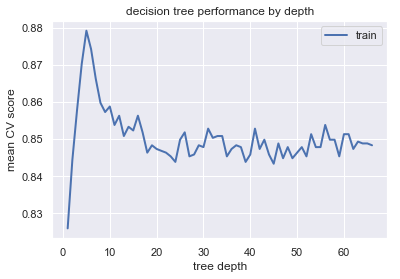

In [601]:
#define depths to test
depths = np.arange(1,pat_df.shape[1],1)
avg_train_score = np.empty(depths.shape, dtype=float)
avg_test_score = np.empty(depths.shape, dtype=float)

# fit decision tree at each depth and record accuracy
for i, depth in enumerate(depths):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=depth).fit(x_train,y_train)
    avg_train_score[i] = cross_val_score(clf, x_train, y_train, cv=5).mean()
    
plt.plot(depths, avg_train_score, c='b', lw=2, label="train")
ax = plt.gca()
ax.set_xlabel("tree depth")
ax.set_ylabel("mean CV score")
ax.legend()
ax.set_title("decision tree performance by depth");

# train clf at best depth and report accuracy
best_depth = depths[np.argmax(avg_train_score)]
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=best_depth).fit(x_train,y_train)
print("Max Train Score at depth = %i" % best_depth)
print("mean accuracy (test): {0:.3f}".format(cross_val_score(best_clf, x_test, y_test, cv=10).mean()))


In [602]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=3).fit(x_train,y_train)
print("mean accuracy (train): {0:.3f}".format(cross_val_score(tree, x_train, y_train, cv=10).mean()))
print("mean accuracy (train): {0:.3f}".format(cross_val_score(tree, x_test, y_test, cv=10).mean()))

mean accuracy (train): 0.858
mean accuracy (train): 0.882


In [603]:
# lets compare it to a bad model
np.histogram(pat_df.DXCOMB.values, bins=[1,2,3,4])[0]/pat_df.shape[0]

array([0.40015911, 0.4363564 , 0.16348449])

In [598]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [604]:
show_tree_structure(best_clf)

The binary tree structure has 31 nodes:

node 0: if X[:, 9] <= 0.992 then go to node 1, else go to node 30
  node 1: if X[:, 0] <= 157.000 then go to node 2, else go to node 17
    node 2: if X[:, 62] <= 74.950 then go to node 3, else go to node 10
      node 3: if X[:, 23] <= 65.250 then go to node 4, else go to node 7
        node 4: if X[:, 50] <= 158.500 then go to node 5, else go to node 6
          node 5: predict class 1
          node 6: predict class 1
        node 7: if X[:, 48] <= 61.000 then go to node 8, else go to node 9
          node 8: predict class 1
          node 9: predict class 3
      node 10: if X[:, 23] <= 62.150 then go to node 11, else go to node 14
        node 11: if X[:, 43] <= 37.500 then go to node 12, else go to node 13
          node 12: predict class 3
          node 13: predict class 3
        node 14: if X[:, 51] <= 10.700 then go to node 15, else go to node 16
          node 15: predict class 3
          node 16: predict class 1
    node 17: if X[:

In [606]:
# print columns in order of importance
splits = [9,0,16,62,23,12,48,43,41]
x_train.columns[splits]

Index(['DXMPTR1', 'ABETA', 'DXPARK', 'TAU', 'HMT15', 'DXMPTR4', 'RCT14',
       'PTAU', 'HMT96'],
      dtype='object')

According to this model, the best predictor is a self-reported memory complaint. 

**PCA**

Let's try some dimensionality reduction with PCA.

In [573]:
# first scale the data from range 0-1
scaler = MinMaxScaler()
scaler = scaler.fit(x_train)
scaled_train = scaler.transform(x_train)
scaled_test = scaler.transform(x_test)

In [589]:
# perform PCA on scaled data and store in new df
pca = PCA(n_components=x_train.shape[1])
pca.fit(scaled_train)

# transform data and store in new dataframe
columns = ['pc_%i' % i for i in range(x_train.shape[1])]
df_pca = pd.DataFrame(pca.transform(scaled_train), columns=columns, index=train_df.index)

# get design matrices for train and test
pca_x_train = df_pca.values
pca_x_test = pca.transform(scaled_test)

# store response var
df_pca["DX"] = y_train

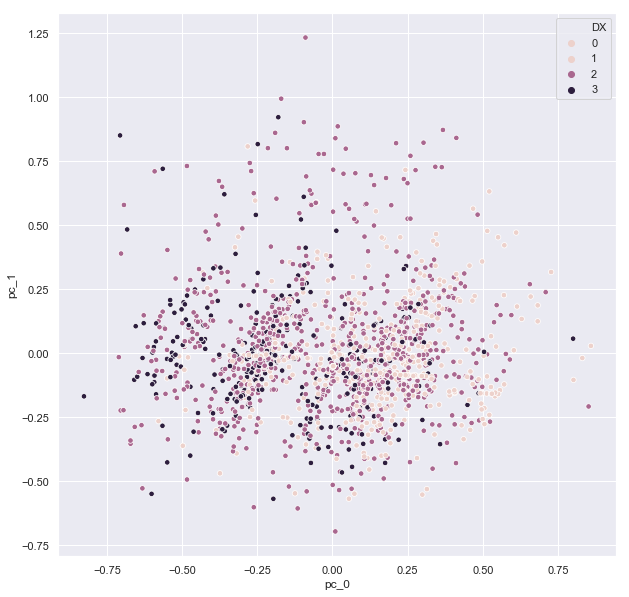

In [590]:
plt.figure(figsize=(10,10))
ax=sns.scatterplot(x="pc_0", y="pc_1", hue="DX", data=df_pca, s=30)

In [597]:
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=2).fit(pca_x_train,y_train)
print("mean accuracy (test): {0:.3f}".format(cross_val_score(best_clf, pca_x_test, y_test, cv=10).mean()))

mean accuracy (test): 0.722
